In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Skin_Diseases_Classification'

In [ ]:
import os

# Verify dataset folder exists and list classes
if os.path.exists(dataset_path):
    classes = os.listdir(dataset_path)
    print("Classes:", classes)
else:
    print(f"Dataset path does not exist: {dataset_path}")

Classes: ['Eczema', 'Rosacea', 'Vitiligo', 'Psoriasis', 'Urticaria Hives', 'Athletes foot', 'Acne']


In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# Create train and val folders
os.makedirs('/content/drive/MyDrive/Skin_Diseases_Classification_result/train', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Skin_Diseases_Classification_result/val', exist_ok=True)

# Split the data
for class_name in classes:
    class_folder = os.path.join(dataset_path, class_name)
    images = os.listdir(class_folder)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    os.makedirs(f'/content/drive/MyDrive/Skin_Diseases_Classification_result/train/{class_name}', exist_ok=True)
    os.makedirs(f'/content/drive/MyDrive/Skin_Diseases_Classification_result/val/{class_name}', exist_ok=True)

    # Move images to train/val folders
    for img in train_images:
        shutil.copy(os.path.join(class_folder, img), f'/content/drive/MyDrive/Skin_Diseases_Classification_result/train/{class_name}')
    for img in val_images:
        shutil.copy(os.path.join(class_folder, img), f'/content/drive/MyDrive/Skin_Diseases_Classification_result/val/{class_name}')




In [ ]:
train_dir = '/content/drive/MyDrive/Skin_Diseases_Classification_result/train'
val_dir = '/content/drive/MyDrive/Skin_Diseases_Classification_result/val'

In [ ]:
!pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 114.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 123.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
])

IMG_SIZE = 224
BATCH_SIZE = 32

train_dir = '/content/drive/MyDrive/Skin_Diseases_Classification_result/train'
val_dir = '/content/drive/MyDrive/Skin_Diseases_Classification_result/val'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode="categorical",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)
class_names = train_ds.class_names
print("Class names:", class_names)


# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

import os

for folder in os.listdir(train_dir):
    print(f"Train {folder}: {len(os.listdir(os.path.join(train_dir, folder)))} images")

for folder in os.listdir(val_dir):
    print(f"Val {folder}: {len(os.listdir(os.path.join(val_dir, folder)))} images")


Found 542 files belonging to 7 classes.
Found 138 files belonging to 7 classes.
Class names: ['Acne', 'Athletes foot', 'Eczema', 'Psoriasis', 'Rosacea', 'Urticaria Hives', 'Vitiligo']
Train Eczema: 86 images
Train Rosacea: 22 images
Train Vitiligo: 59 images
Train Psoriasis: 63 images
Train Urticaria Hives: 137 images
Train Athletes foot: 123 images
Train Acne: 52 images
Val Acne: 13 images
Val Eczema: 22 images
Val Rosacea: 6 images
Val Vitiligo: 15 images
Val Psoriasis: 16 images
Val Urticaria Hives: 35 images
Val Athletes foot: 31 images


In [ ]:
import os
import numpy as np
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# ✅ Extract train_labels from tf.data.Dataset (train_ds)
all_labels = []
for _, labels in train_ds:
    all_labels.extend(np.argmax(labels.numpy(), axis=1))
train_labels = np.array(all_labels)

# ✅ Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# ✅ Set up model
IMG_SIZE = 224
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = MobileNetV2(include_top=False, input_tensor=input_layer, weights='imagenet')
base_model.trainable = False

for layer in base_model.layers[-10:]:
    layer.trainable = True

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.7)(x)

num_classes = len(class_weights)
output_layer = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=input_layer, outputs=output_layer)




/tmp/ipython-input-11-2104977594.py:28: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=input_layer, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)


In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6
)




In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[ lr_scheduler, checkpoint],
    class_weight=class_weights
)







/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.2185 - loss: 2.2992 - val_accuracy: 0.3986 - val_loss: 1.6545 - learning_rate: 0.0010
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.3872 - loss: 1.5835 - val_accuracy: 0.5000 - val_loss: 1.5196 - learning_rate: 0.0010
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.4824 - loss: 1.4379 - val_accuracy: 0.5290 - val_loss: 1.4681 - learning_rate: 0.0010
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.4973 - loss: 1.4039 - val_accuracy: 0.5290 - val_loss: 1.4679 - learning_rate: 0.0010
Epoch 5/20
17/17 ━━━━━━━━━━

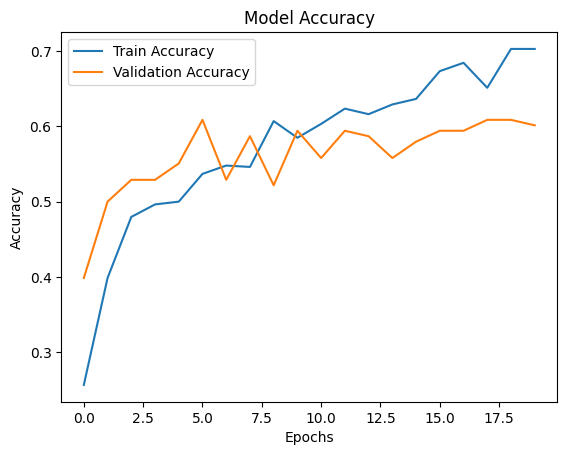

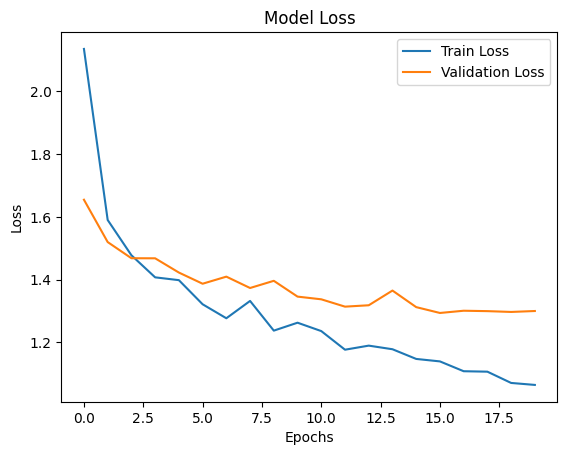

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()



In [ ]:
model.save('skin_disease_model.keras')


# Steps Recap
# Here are the complete steps you need to follow:

# Mount Google Drive: Ensure dataset is accessible.
# Set Dataset Paths: Verify folder structure and paths.
# Preprocess Dataset: Use ImageDataGenerator for rescaling and loading.
# Build CNN Model: Define and compile the CNN architecture.
# Train the Model: Train the model on training data.
# Evaluate the Model: Check accuracy and loss on validation data.
# Visualize Performance: Plot training/validation accuracy and loss.



In [ ]:
# Model Accuracy and Model Loss are two key metrics used to evaluate the performance of machine learning models, especially in classification tasks. Here's what each tells you:

# 1. Model Accuracy:
# Definition: Accuracy measures the proportion of correct predictions made by the model out of all predictions. It is the ratio of correct predictions (both true positives and true negatives) to the total number of predictions.

# Formula:

# Accuracy
# =
# Number of Correct Predictions
# Total Predictions
# Accuracy=
# Total Predictions
# Number of Correct Predictions
# ​

# What it tells us:

# A high accuracy means that the model is making correct predictions most of the time.
# However, accuracy might not be a reliable metric in imbalanced datasets, where one class is much more frequent than others. In such cases, the model might predict the dominant class most of the time, leading to high accuracy but poor performance for the minority class.
# Interpretation:

# For example, if your model has 80% accuracy, it means that 80% of the time, the model's predictions match the true labels.
# 2. Model Loss:
# Definition: Loss quantifies how far off the model's predictions are from the actual values. It measures the error or difference between predicted and actual values. Lower loss indicates that the model's predictions are closer to the true values.

# What it tells us:

# Training Loss: The error on the training set. A low training loss suggests that the model is fitting well to the training data.
# Validation Loss: The error on the validation set. This is critical for understanding how well the model generalizes to unseen data. A high validation loss suggests that the model is overfitting (i.e., it has learned the training data too well but is failing to generalize to new data).
# Interpretation:

# For example, if the model loss is high, it means that the predictions are far from the true values, indicating poor model performance. A lower loss implies better model performance in terms of prediction accuracy.
# During training, you want both the training loss and validation loss to decrease. If the training loss decreases but validation loss increases, it might indicate overfitting.
# Key Insights:
# Accuracy is a high-level measure of how often the model gets the right prediction.
# Loss provides a deeper view of how "wrong" the model is on average when it makes an incorrect prediction. It's used by optimization algorithms to adjust the model weights.
# Together:

# High accuracy with low loss: Indicates a well-performing model.
# High accuracy with high loss: Indicates that the model is making some correct predictions but still struggling with others.
# Low accuracy with low loss: Suggests that the model is not making accurate predictions but is still somewhat consistent in its errors.
# Low accuracy with high loss: Indicates poor model performance in both accuracy and consistency.
# In summary, accuracy tells you how often the model is right, while loss tells you how wrong the model is when it's incorrect.








In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predict_image(img_path, model, class_names, img_size=224):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    # Show image with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

    return predicted_class


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


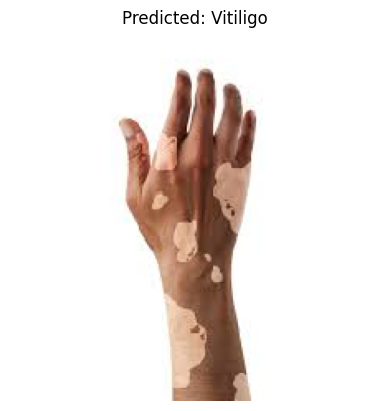

'Vitiligo'

In [ ]:
img_path = '/content/drive/MyDrive/Skin_Diseases_Classification_result/val/Vitiligo/images56.jpeg' # Replace with your test image
predict_image(img_path, model, class_names)
